In [1]:
import os
import random
import numpy as np
import copy
from PIL import Image  

import PIL.Image as pil
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage.transform
from collections import Counter
import time

import json


## Some helper functions are used from the original implementation
from utils import *
from layers import *
#from kitti_utils import *
#from layers import *


#import datasets
import networks
from IPython import embed


cuda = torch.cuda.is_available()
cuda

True

In [2]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [3]:
class MainDataset(data.Dataset):
    
    def __init__(self,data_path,filenames,height,width,frame_idxs,num_scales,is_train=False,img_ext='.jpg'):
        super(MainDataset, self).__init__()
        
        self.data_path = data_path
        self.filenames = filenames
        self.height = height
        self.width = width
        self.num_scales = num_scales
        self.frame_idxs = frame_idxs
        self.is_train = is_train
        self.img_ext = img_ext
        
        # Interpolation Method during Scaling of the Images
        self.interp = Image.ANTIALIAS 
        
        self.loader = pil_loader
        self.to_tensor = transforms.ToTensor()
        
        # Randomly Change the Brightness, Contrast, Saturation and Hue of the Image
        # Tuple: (min,max)
        self.brig = (0.8,1.2)
        self.con = (0.8,1.2)
        self.sat = (0.8,1.2)
        self.hue = (-0.1, 0.1)
        # transforms.ColorJitter.get_params(brightness=(0.8,1.2),contrast=(0.8,1.2),saturation=(0.8,1.2),hue=(-0.1, 0.1))
        
        # Create a Dictionary (self.resize) of size of all the images after scaling
        # Scale = -1:(1242,375) - Native Resolution as loaded
        # Scale = 0:(192,640)  # Scale = 1:(96,320) # Scale = 2:(48,160) # Scale = 3:(24,80)
        # Interpolation while scaling = PIL.Image.LANCZOS
        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s),interpolation=self.interp)
            
        self.load_depth = self.check_depth()
        
        # Intrinsic Camera Matrix
        self.K = np.array([[0.58, 0, 0.5, 0],[0, 1.92, 0.5, 0],[0, 0, 1, 0],[0, 0, 0, 1]], dtype=np.float32)
        
        # Dimensions of the Original Image 
        self.full_res_shape = (1242, 375)
        
        self.side_map = {"2": 2, "3": 3, "l": 2, "r": 3}
    
    def __len__(self):
        return len(self.filenames)
    
    
    # Checks if the Loaded Filenames contains Velodyne Points a.k.a. Checks Depth if it exists
    def check_depth(self):
        
        line = self.filenames[0].split() # ['2011_09_26/2011_09_26_drive_0022_sync', '473', 'r']
        scene_name = line[0] # 2011_09_26/2011_09_26_drive_0022_sync
        frame_index = int(line[1]) # 473

        velo_filename = os.path.join(self.data_path,scene_name,"velodyne_points/data/{:010d}.bin".format(int(frame_index)))
        # /home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0022_sync/velodyne_points/data/0000000473.bin
        
        check_depth_boolean = os.path.isfile(velo_filename)
        
        return check_depth_boolean
    
    def get_image_path(self, folder, frame_index, side):
        
        f_str = "{:010d}{}".format(frame_index, self.img_ext)
        image_path = os.path.join(self.data_path, folder, "image_0{}/data".format(self.side_map[side]), f_str)
        # Ex: /home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0022_sync/image_03/data/0000000473.jpg
        
        return image_path
    
    def get_depth(self, folder, frame_index, side):
        
        # Data Path Ex: /home/ubuntu/monodepth2/kitti_data
        # Folder Ex: 2011_09_26/2011_09_26_drive_0022_sync
        
        calib_path = os.path.join(self.data_path, folder.split("/")[0])
        # Calib_Path Ex: /home/ubuntu/monodepth2/kitti_data/2011_09_26

        velo_filename = os.path.join(self.data_path,folder,"velodyne_points/data/{:010d}.bin".format(int(frame_index)))
        # Velo_Filename Ex: 
        # /home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0022_sync/velodyne_points/data/0000000473.bin

        depth_gt = self.generate_depth_map(calib_path, velo_filename, self.side_map[side])
        # Shape of depth_gt: (375, 1242)
        depth_gt = skimage.transform.resize(depth_gt, self.full_res_shape[::-1], order=0, preserve_range=True, mode='constant')
        # Shape of depth_gt: (375, 1242)
        
        return depth_gt
    
    def load_velodyne_points(self,filename):

        points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
        points[:, 3] = 1.0  # homogeneous
        return points
    
    def read_calib_file(self,path):

        float_chars = set("0123456789.e+- ")
        data = {}
        with open(path, 'r') as f:
            for line in f.readlines():
                key, value = line.split(':', 1)
                value = value.strip()
                data[key] = value
                if float_chars.issuperset(value):
                    # try to cast to float array
                    try:
                        data[key] = np.array(list(map(float, value.split(' '))))
                    except ValueError:
                        # casting error: data[key] already eq. value, so pass
                        pass

        return data
    
    def sub2ind(self,matrixSize, rowSub, colSub):

        m, n = matrixSize
        return rowSub * (n-1) + colSub - 1
    
    def generate_depth_map(self,calib_dir, velo_filename, cam=2, vel_depth=False):

        # load calibration files
        cam2cam = self.read_calib_file(os.path.join(calib_dir, 'calib_cam_to_cam.txt'))
        velo2cam = self.read_calib_file(os.path.join(calib_dir, 'calib_velo_to_cam.txt'))
        velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'][..., np.newaxis]))
        velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

        # get image shape
        im_shape = cam2cam["S_rect_02"][::-1].astype(np.int32)

        # compute projection matrix velodyne->image plane
        R_cam2rect = np.eye(4)
        R_cam2rect[:3, :3] = cam2cam['R_rect_00'].reshape(3, 3)
        P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3, 4)
        P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

        # load velodyne points and remove all behind image plane (approximation)
        # each row of the velodyne data is forward, left, up, reflectance
        velo = self.load_velodyne_points(velo_filename)
        velo = velo[velo[:, 0] >= 0, :]

        # project the points to the camera
        velo_pts_im = np.dot(P_velo2im, velo.T).T
        velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

        if vel_depth:
            velo_pts_im[:, 2] = velo[:, 0]

        # check if in bounds
        # use minus 1 to get the exact same value as KITTI matlab code
        velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
        velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
        val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
        val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
        velo_pts_im = velo_pts_im[val_inds, :]

        # project to image
        depth = np.zeros((im_shape[:2]))
        depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

        # find the duplicate points and choose the closest depth
        inds = self.sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
        dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
        for dd in dupe_inds:
            pts = np.where(inds == dd)[0]
            x_loc = int(velo_pts_im[pts[0], 0])
            y_loc = int(velo_pts_im[pts[0], 1])
            depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
        depth[depth < 0] = 0

        return depth
    
    def __getitem__(self,index):
        
        # The dictionary to be returned as a single training item
        inputs = {}
        
        do_color_aug = self.is_train and random.random() > 0.5
        do_flip = self.is_train and random.random() > 0.5
        
        line = self.filenames[index].split() # Ex: ['2011_09_26/2011_09_26_drive_0022_sync', '473', 'r']
        folder = line[0] # Ex: 2011_09_26/2011_09_26_drive_0022_sync
        
        if len(line) == 3:
            frame_index = int(line[1])
            side = line[2]
        else:
            frame_index = 0
            side = None
        
        
        # Append the images for each frame in the dictionary
        # Flip if do_flip is True
        for i in self.frame_idxs:
            
            if i != "s": # For Non Stereo
                
                color = self.loader(self.get_image_path(folder, frame_index + i, side))
                if do_flip == True:
                    color = color.transpose(pil.FLIP_LEFT_RIGHT)
                
                inputs[("color", i, -1)] = color
            
            else: #For Stereo
                
                other_side = {"r": "l", "l": "r"}[side]
                color = self.loader(self.get_image_path(folder, frame_index, other_side))
                if do_flip == True:
                    color = color.transpose(pil.FLIP_LEFT_RIGHT)
                    
                inputs[("color", i, -1)] = color
                
        
        # Construct the intrinsics for each scale and Append in the dictionary
        for scale in range(self.num_scales):
            
            K_scale = self.K.copy()
            K_scale[0,:] = K_scale[0,:] * (self.width // (2 ** scale))
            K_scale[1,:] = K_scale[1,:] * (self.height // (2 ** scale))
            
            # Compute the (Moore-Penrose) pseudo-inverse of a matrix.
            inverse_K_scale = np.linalg.pinv(K_scale)
            
            # Append K and its inverse for the particular 'scale'
            inputs[("K", scale)] = torch.from_numpy(K_scale)
            inputs[("inv_K", scale)] = torch.from_numpy(inverse_K_scale)
            
        # If Color Augmentation is True
        # Define color_aug to transform the image by changing its brightness, contrast, saturation and hue
        if do_color_aug == True:
            color_aug = transforms.ColorJitter.get_params(
                self.brig, self.con, self.sat, self.hue)
        else:
            color_aug = (lambda x: x)    
        
        
        # Till now, inputs contains images for all frames for only scale = -1
        # Append "color" images (and preprocessed to tensors) for all frames for other scales = 0,1,2,3 
        # Do similar and append for "color_aug" images do_color_aug is True
        # --->
        
        for k in list(inputs):
            frame = inputs[k]
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])
            
        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = self.to_tensor(f)
                inputs[(n + "_aug", im, i)] = self.to_tensor(color_aug(f))
                
        # <---
        
        # Delete the scale of -1 as it indicates the default image resolution not required for training purposes
        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
            del inputs[("color_aug", i, -1)]
                
        # Load Depth for the Images and Append to the dictionary of inputs
        if self.load_depth:
            depth_gt = self.get_depth(folder, frame_index, side)
            # Shape of depth_gt: (375, 1242)
            inputs["depth_gt"] = np.expand_dims(depth_gt, 0)
            inputs["depth_gt"] = torch.from_numpy(inputs["depth_gt"].astype(np.float32))
        
        # For Stereo
        if "s" in self.frame_idxs:
            stereo_T = np.eye(4, dtype=np.float32)
            baseline_sign =  -1 if do_flip else 1
            side_sign = -1 if side == "l" else 1
            stereo_T[0, 3] = side_sign * baseline_sign * 0.1

            inputs["stereo_T"] = torch.from_numpy(stereo_T)

        
        return inputs
        
        

In [4]:
## Load the data according to files listed in eigen_full split 

dataset =  MainDataset #datasets.KITTIRAWDataset
data_path = "/home/ubuntu/monodepth2/kitti_data"
fpath_train = "/home/ubuntu/monodepth2/splits/eigen_full/train_files.txt"
f_train = open(fpath_train)
train_filenames = f_train.readlines()
fpath_val = "/home/ubuntu/monodepth2/splits/eigen_full/val_files.txt"
f_val = open(fpath_val)
val_filenames = f_val.readlines()

In [5]:
## Size to rescale all input images to
height = 192
width = 640

## Scales of the output image from each layer of the decoder
## output scale = input scale/2**(n) for n in scales
scales = np.arange(4)

img_ext = '.jpg'
device = torch.device("cuda" if cuda else "cpu")

## List of frames that the dataloader must return 
## 0 - present frame
## 's' - stereo couple frame
frame_ids = [0,'s']

num_layers = 18
weights_init = 'pretrained'
weights_pretrained = True

num_scales = len(scales)
num_input_frames = len(frame_ids)

learning_rate = 0.0001

In [28]:
batch_size = 4
num_workers = 8

train_dataset = dataset(data_path, train_filenames, height, width,frame_ids,num_scales,is_train=True, img_ext=img_ext)
train_loader = DataLoader(train_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

val_dataset = dataset(data_path, val_filenames, height, width,frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(val_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

In [7]:
params = []

## Initialize the models

encoder = networks.ResnetEncoder(num_layers, weights_init == "pretrained")
params += list(encoder.parameters())


decoder = networks.DepthDecoder(encoder.num_ch_enc, scales)
params += list(decoder.parameters())


ssim = SSIM()
ssim.to(device)

encoder.to(device)
decoder.to(device)
optimizer = optim.Adam(params, learning_rate)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

depth_metric_names = [
            "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]


In [8]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)

#print("There are {:d} training items and {:d} validation items\n".format(len(train_dataset), len(val_dataset)))

In [9]:

def generate_images_pred(inputs, outputs):
        
   
    source_scale = 0
    
    for scale in scales:
        disp = outputs[("disp", scale)]

        disp = F.interpolate(disp, [height, width], mode="bilinear",align_corners=False)
        
        depth = 1 / (0.01 + 9.99*disp)
 
        outputs[("depth", 0, scale)] = depth

        T = inputs["stereo_T"]

        cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)])
        pix_coords = project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)
        outputs[("color", 's', scale)] = F.grid_sample(inputs[("color", 's', source_scale)],
                pix_coords,
                padding_mode="border",align_corners=False)

    return outputs   


In [10]:

def compute_reprojection_loss(pred, target):

        l1_loss = (torch.abs(target - pred)).mean(1,True)
        
        ssim_loss = ssim(pred, target).mean(1, True)
        reprojection_loss = 0.85*ssim_loss + 0.15 * l1_loss

        return reprojection_loss


In [11]:
def get_smooth_loss(disp, img):

    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()


In [12]:

def compute_losses(inputs, outputs):

        losses = {}
        total_loss = 0
        

        for scale in scales:
            loss = 0
            reprojection_losses = []

            source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]


            pred = outputs[("color", 's', scale)]
            reprojection_losses.append(compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            to_optimise, idxs = torch.min(reprojection_losses, dim=1)
            #to_optimise = reprojection_losses
            loss = loss + to_optimise.mean()

            norm_disp = disp / (disp.mean(2, True).mean(3, True)+ 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss =  loss + ((1e-3)*smooth_loss) / (2 ** scale)
            total_loss = total_loss + loss
            losses["loss/{}".format(scale)] = loss

        total_loss = total_loss/num_scales
        losses["loss"] = total_loss
        return losses



In [13]:

def compute_depth_losses(inputs, outputs, losses):


        depth_pred = outputs[("depth", 0, 0)]
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), min=1e-3, max=80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        gt = depth_gt[mask]
        pred = depth_pred[mask]
        pred = pred*(torch.median(gt) / torch.median(pred))

        pred = torch.clamp(pred, min=1e-3, max=80)
        thresh = torch.max((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).float().mean()
        a2 = (thresh < 1.25 ** 2).float().mean()
        a3 = (thresh < 1.25 ** 3).float().mean()

        rmse = torch.sqrt(((gt - pred)**2).mean())
        rmse_log = torch.sqrt(((torch.log(gt) - torch.log(pred))**2).mean())
        abs_rel = torch.mean(torch.abs(gt - pred) / gt)
        sq_rel = torch.mean(((gt - pred)**2 )/ gt)
        
        return np.array([abs_rel.item(),sq_rel.item(),rmse.item(),rmse_log.item(),a1.item(),a2.item(),a3.item()])


In [14]:
def train(encoder,decoder,train_loader,val_loader,num_epochs):
              
        encoder.train()
        decoder.train()
        
        for epoch in range(num_epochs):
            lr_scheduler.step()
            total_loss = 0 
            outer = tqdm(total=(len(train_loader)), desc='Training Epoch', position=0)

            for batch_idx, inputs in enumerate(train_loader):

                outer.update(1)
                optimizer.zero_grad()


                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputsl = decoder(features)

       
                outputs = generate_images_pred(inputs, outputsl)
                

                losses = compute_losses(inputs, outputs)
                total_loss = total_loss + losses['loss'].item()
                
                losses["loss"].backward()
                optimizer.step()
                #lr_scheduler.step()

                del inputs, outputs, features
                if batch_idx%1000==0 and batch_idx>0:
                    print('Batch No: ',batch_idx)
                    #print('Loss: ',total_loss/(batch_idx+1))
                    print('Loss: ',losses["loss"].cpu().data)
                del losses
                    
  
            total_loss = total_loss/len(train_loader)
            print('Train Loss at Epoch_{}:'.format(epoch+1),total_loss)
            validation(encoder,decoder,val_loader)

In [15]:
def validation(encoder,decoder,val_loader):
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        metrics = np.zeros((7))
        for batch_idx, inputs in enumerate(val_loader):

            before_op_time = time.time()

            for key, ipt in inputs.items():
                inputs[key] = ipt.to(device)

            features = encoder(inputs["color_aug", 0, 0])
            outputs = decoder(features)
            
            outputs = generate_images_pred(inputs, outputs)
            losses = compute_losses(inputs, outputs)
            total_loss = total_loss + losses['loss'].item()
         
            metrics = metrics + compute_depth_losses(inputs, outputs, losses)
            del inputs, outputs, losses,features
         
        total_loss = total_loss/len(val_loader)
        print('Total Loss (Validation): ',total_loss)
        print('Error Metrics: ',metrics/len(val_loader))      

In [16]:
num_epochs = 2
train(encoder,decoder,train_loader,val_loader,num_epochs)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Training Epoch:   9%|▉         | 1003/11300 [04:03<39:45,  4.32it/s] 

Batch No:  1000
Loss:  tensor(0.1403)


Training Epoch:  18%|█▊        | 2003/11300 [08:02<25:06,  6.17it/s]  

Batch No:  2000
Loss:  tensor(0.1680)


Training Epoch:  27%|██▋       | 3002/11300 [12:04<24:54,  5.55it/s]  

Batch No:  3000
Loss:  tensor(0.1383)


Training Epoch:  35%|███▌      | 4003/11300 [16:07<26:39,  4.56it/s]  

Batch No:  4000
Loss:  tensor(0.1400)


Training Epoch:  44%|████▍     | 5003/11300 [20:05<21:58,  4.77it/s]  

Batch No:  5000
Loss:  tensor(0.1493)


Training Epoch:  53%|█████▎    | 6003/11300 [24:04<14:59,  5.89it/s]

Batch No:  6000
Loss:  tensor(0.1552)


Training Epoch:  62%|██████▏   | 7002/11300 [28:04<14:18,  5.01it/s]

Batch No:  7000
Loss:  tensor(0.1384)


Training Epoch:  71%|███████   | 8003/11300 [32:04<10:00,  5.49it/s]

Batch No:  8000
Loss:  tensor(0.2092)


Training Epoch:  80%|███████▉  | 9003/11300 [36:02<08:19,  4.60it/s]

Batch No:  9000
Loss:  tensor(0.1569)


Training Epoch:  89%|████████▊ | 10002/11300 [40:01<03:48,  5.68it/s]

Batch No:  10000
Loss:  tensor(0.1320)


Training Epoch:  97%|█████████▋| 11002/11300 [44:00<00:57,  5.14it/s]

Batch No:  11000
Loss:  tensor(0.1514)


Training Epoch: 100%|██████████| 11300/11300 [45:11<00:00,  7.47it/s]

Train Loss at Epoch_1: 0.15500665542364647


Training Epoch:   0%|          | 0/11300 [00:00<?, ?it/s]

Total Loss (Validation):  0.140254799209468
Error Metrics:  [0.12716943 1.35799062 5.68307211 0.21207016 0.86225265 0.94999396
 0.97816503]


Training Epoch:   1%|▏         | 161/11300 [00:40<30:49,  6.02it/s]  

KeyboardInterrupt: 

In [29]:
num_epochs = 1
train(encoder,decoder,train_loader,val_loader,num_epochs)

Training Epoch:   9%|▉         | 1003/11300 [04:05<31:02,  5.53it/s] 

Batch No:  1000
Loss:  tensor(0.1170)


Training Epoch:  18%|█▊        | 2003/11300 [08:12<29:04,  5.33it/s]  

Batch No:  2000
Loss:  tensor(0.1848)


Training Epoch:  27%|██▋       | 3003/11300 [12:17<26:34,  5.20it/s]  

Batch No:  3000
Loss:  tensor(0.1351)


Training Epoch:  35%|███▌      | 4002/11300 [16:21<22:17,  5.46it/s]  

Batch No:  4000
Loss:  tensor(0.1561)


Training Epoch:  44%|████▍     | 5002/11300 [20:23<21:54,  4.79it/s]  

Batch No:  5000
Loss:  tensor(0.1243)


Training Epoch:  53%|█████▎    | 6001/11300 [24:28<17:28,  5.05it/s]

Batch No:  6000
Loss:  tensor(0.1409)


Training Epoch:  62%|██████▏   | 7001/11300 [28:33<20:03,  3.57it/s]

Batch No:  7000
Loss:  tensor(0.1289)


Training Epoch:  71%|███████   | 8002/11300 [32:38<12:18,  4.47it/s]

Batch No:  8000
Loss:  tensor(0.1457)


Training Epoch:  80%|███████▉  | 9003/11300 [36:39<06:49,  5.61it/s]

Batch No:  9000
Loss:  tensor(0.1499)


Training Epoch:  89%|████████▊ | 10001/11300 [40:41<03:44,  5.80it/s]

Batch No:  10000
Loss:  tensor(0.1224)


Training Epoch:  97%|█████████▋| 11003/11300 [44:48<00:55,  5.40it/s]

Batch No:  11000
Loss:  tensor(0.1253)


Training Epoch: 100%|██████████| 11300/11300 [46:01<00:00,  7.16it/s]

Train Loss at Epoch_1: 0.1389364613612405
Total Loss (Validation):  0.1348713036156721
Error Metrics:  [0.1079041  1.09396858 4.90795733 0.19796024 0.89286762 0.95850069
 0.98024142]


In [30]:
i = 0
total_loss = 0
train_loader = val_loader
for batch_idx, inputs in enumerate(train_loader):
                optimizer.zero_grad()

                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputs = decoder(features)
               
                o1 = generate_images_pred(inputs, outputs)
                
                losses = compute_losses(inputs, o1)
                
                total_loss = total_loss + losses['loss'].item()
                optimizer.zero_grad()
                losses["loss"].backward()
                optimizer.step()
                i = i+1
                
                lr_scheduler.step()
                
                if i>2:
                    break
                   
                del inputs, outputs, losses,features,o1
                

In [31]:
outputs[('disp', 3)]

tensor([[[[0.0373, 0.0345, 0.0336,  ..., 0.0253, 0.0220, 0.0212],
          [0.0382, 0.0358, 0.0356,  ..., 0.0297, 0.0256, 0.0255],
          [0.0350, 0.0348, 0.0351,  ..., 0.0319, 0.0272, 0.0264],
          ...,
          [0.0802, 0.0806, 0.0790,  ..., 0.0879, 0.0854, 0.0970],
          [0.0925, 0.0881, 0.0877,  ..., 0.0941, 0.0886, 0.1037],
          [0.0968, 0.0940, 0.0921,  ..., 0.1007, 0.0964, 0.1101]]],


        [[[0.0290, 0.0298, 0.0290,  ..., 0.0271, 0.0310, 0.0349],
          [0.0264, 0.0279, 0.0255,  ..., 0.0293, 0.0303, 0.0325],
          [0.0214, 0.0236, 0.0225,  ..., 0.0301, 0.0295, 0.0336],
          ...,
          [0.0645, 0.0646, 0.0661,  ..., 0.1018, 0.0985, 0.1089],
          [0.0684, 0.0719, 0.0698,  ..., 0.0890, 0.0928, 0.1052],
          [0.0785, 0.0818, 0.0795,  ..., 0.0935, 0.0916, 0.0987]]],


        [[[0.0354, 0.0324, 0.0336,  ..., 0.0373, 0.0388, 0.0394],
          [0.0355, 0.0324, 0.0323,  ..., 0.0386, 0.0397, 0.0412],
          [0.0365, 0.0327, 0.0330,  ..

In [32]:
image_path = "/home/ubuntu/monodepth2/assets/test_image.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [33]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    features = encoder(input_image_pytorch.to(device))
    outputs = decoder(features)

disp = outputs[("disp", 0)]

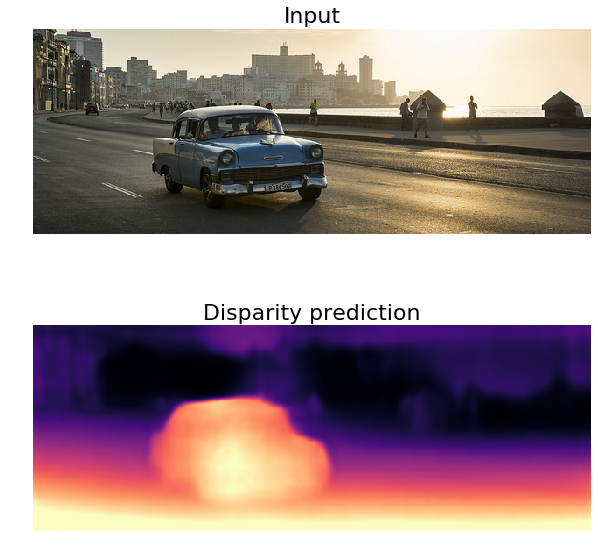

In [34]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');